In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from datetime import datetime
from sklearn.metrics import make_scorer
import numpy as np

Data import

In [5]:
df_train = pd.read_csv('https://raw.githubusercontent.com/btlgs2000/machine_learning_basic/master/data/houses_train.csv')
#elimino i prezzi a zero e gli outlier
df_train = df_train.loc[(df_train['price']>df_train['price'].quantile(0.05)) & (df_train['price']<=df_train['price'].quantile(0.95))]
df_train.shape

(3308, 19)

In [6]:
df_test_final = pd.read_csv('https://raw.githubusercontent.com/btlgs2000/machine_learning_basic/master/data/houses_test_no_price.csv')
df_test_final.shape

(920, 18)

In [7]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2315,2014-06-11 00:00:00,700000.0,3.0,2.75,2500,7378,1.0,0,0,5,1390,1110,1948,1985,10050 11th Ave NW,Seattle,WA 98177,USA
1,1434,2014-05-28 00:00:00,225000.0,3.0,2.00,2030,24829,1.0,0,0,4,1220,810,1979,0,36721 34th Ave S,Auburn,WA 98001,USA
2,1412,2014-05-27 00:00:00,754950.0,3.0,2.50,2610,7256,2.0,0,0,3,2610,0,2014,0,12108 NE 106th Pl,Kirkland,WA 98033,USA
3,3837,2014-07-02 00:00:00,411000.0,4.0,2.00,2370,76665,2.0,0,0,4,2370,0,1978,2000,35516 44th Ave S,Auburn,WA 98001,USA
4,4267,2014-07-09 00:00:00,215000.0,3.0,1.00,1200,7280,1.0,0,0,4,1200,0,1967,0,4503 S 256th St,Kent,WA 98032,USA


Data manipulation

In [8]:
#trasformo la data in stringa ed estraggo il mese

In [9]:
df_train['date'] = df_train['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df_train['mese'] = df_train['date'].dt.month
df_test_final['date'] = df_test_final['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df_test_final['mese'] = df_test_final['date'].dt.month

In [10]:
df_train.shape, df_test_final.shape

((3308, 20), (920, 19))

In [ ]:
#creo un test set su cui valutare poi il modello

In [11]:
X = df_train.drop('price', axis=1)
y = df_train['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

In [12]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [13]:
#creo una copia per tenere intatto df_train --> mi servirà poi in cv
df_train_new = df_train.copy()

In [15]:
#funzione per target encoding --> targetizzo alcune categoriche usando i quartili del prezzo (calcolati solo sul train)
def quantili_col(df, col, n_quantili):
  grouped = pd.DataFrame(df.groupby([col])['price'].agg(['mean', 'count'])).reset_index()
  grouped['quantili_'+col] = pd.qcut(grouped['mean'], n_quantili, labels=range(1,n_quantili+1))
  return grouped[[col, 'quantili_'+col]]

In [16]:
list_df = [df_train_new, df_test, df_test_final]
for i, df in enumerate(list_df):
  for col in ['city', 'statezip']:
    list_df[i] = list_df[i].merge(quantili_col(df_train, col, 4), on =col, how ='left')
    list_df[i]['quantili_'+col]=list_df[i]['quantili_'+col].astype(float)

In [17]:
df_train_new, df_test, df_test_final = list_df

In [18]:
df_train_new.shape, df_test.shape, df_test_final.shape

((2646, 22), (662, 22), (920, 21))

In [19]:
X_train = df_train_new.drop('price', axis=1)
y_train = df_train_new['price']
X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

In [20]:
#droppo le colonne che non uso nel modello da tutti e 3 i dataset che ho a disposizione
col_to_remove = ['date', 'country', 'street', 'city', 'statezip', 'id']
X_train = X_train.drop(col_to_remove, axis=1)
X_test = X_test.drop(col_to_remove, axis=1)
df_test_final = df_test_final.drop(col_to_remove, axis=1)

In [21]:
X_train.shape, y_train.shape

((2646, 15), (2646,))

RandomSearch and model building 

In [22]:
param_dist = {"learning_rate": [0.2, 0.3, 0.1, 0.01, 0.001],
                   "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                   "max_depth": [1, 2, 4, 7, 10],
                   "colsample_bytree": [0.3, 0.6, 0.8, 1.0, 1.2, 1.4],
                   "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
                   "reg_alpha": [0, 0.5, 1],
                   "reg_lambda": [1, 1.5, 2, 3, 4.5],
                   "min_child_weight": [1, 3, 5, 7],
                   "n_estimators": [50, 70, 100, 250, 500, 1000]
                 }

In [23]:
xgb_model= xgb.XGBRegressor()

In [24]:
def mape(y_true, y_pred):
  return (np.abs((y_true - y_pred)/(y_true+1))).mean()

mape_scorer = make_scorer(mape, greater_is_better=False)

In [25]:
folds = 5
param_comb = 5

kf = KFold(n_splits=folds, shuffle = True, random_state = 2019)

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=param_comb, scoring=mape_scorer, n_jobs=-1, cv=kf.split(X_train,y_train), verbose=3, random_state=40)

In [26]:
random_search.fit(X_train.values, y_train.values)

print('\n Best normalized score for %d-fold search:' % (folds))
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_estimator_.get_params())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.4s finished


[05:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 Best normalized score for 5-fold search:
-0.15537763102108482

 Best hyperparameters:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 1, 'importance_type': 'gain', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1000, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0.5, 'reg_lambda': 2, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.2, 'verbosity': 1}


In [27]:
params = {'base_score': 0.5, 
          'booster': 'gbtree', 
          'colsample_bylevel': 1, 
          'colsample_bynode': 1, 
          'colsample_bytree': 0.8, 
          'gamma': 1, 
          'importance_type': 'gain', 
          'learning_rate': 0.01, 
          'max_delta_step': 0, 
          'max_depth': 4, 
          'min_child_weight': 1, 
          'missing': None, 
          'n_estimators': 1000, 
          'n_jobs': -1, 
          'nthread': None, 
          'objective': 'reg:linear', 
          'random_state': 2019, 
          'reg_alpha': 0.5, 
          'reg_lambda': 2, 
          'scale_pos_weight': 1, 
          'subsample': 0.2, 
          'verbosity': 1}

Model testing in 5folds cv

In [28]:
scores = []
for train_index, test_index in kf.split(df_train.values):
  df_tr, df_te = df_train.iloc[train_index], df_train.iloc[test_index]

  list_df = [df_tr, df_te]
  for i, df in enumerate(list_df):
    for col in ['city', 'statezip']:
      list_df[i] = list_df[i].merge(quantili_col(df_tr, col, 4), on =col, how ='left')
      list_df[i]['quantili_'+col]=list_df[i]['quantili_'+col].astype(float)
    
  df_tr, df_te = list_df
  
  y_tr = df_tr['price']
  y_te = df_te['price']
  X_tr = df_tr.drop('price', axis=1)
  X_te = df_te.drop('price', axis=1)

  #print(X_tr.columns)
  X_tr = X_tr.drop(col_to_remove, axis=1)
  X_te = X_te.drop(col_to_remove, axis=1)

  xgb_model = xgb.XGBRegressor(**params)
  xgb_model.fit(X_tr.values, y_tr.values)
    
  y_pred = xgb_model.predict(X_te.values)
  scores.append(mape(y_te.values, y_pred))


[06:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
np.mean(scores)

0.1570952990016222

Layer esplicativo

[06:15:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


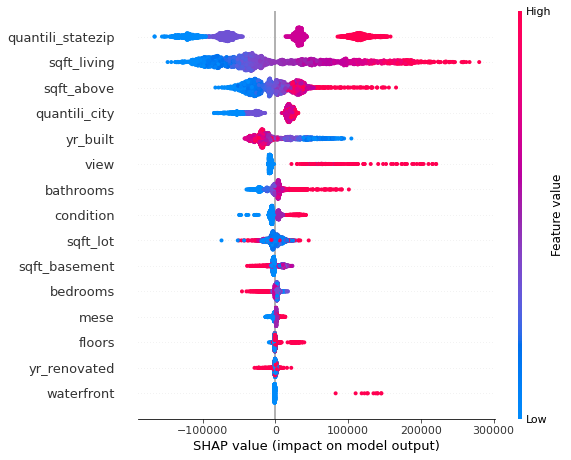

In [32]:
#!pip3 install shap
import shap
## model
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train.values, y_train.values)
## explainer
explainer = shap.TreeExplainer(xgb_model)
#
## compute shap values
shap_values = explainer.shap_values(X_train)
## shap_values = explainer.shap_values(df_train[x_columns])
#
## summarize the effects of all the features
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display = int(X_train.shape[0]))

Model performance -- test set

In [33]:
y_pred = xgb_model.predict(X_test.values)

In [34]:
mape(y_test, y_pred)

0.15581706537967868

Results

In [35]:
y_pred_final = xgb_model.predict(df_test_final.values)
y_pred_final.shape

(920,)

In [36]:
pred = pd.DataFrame(y_pred_final)
pred.rename(columns={0: 'pred'}, inplace=True)

In [37]:
df_test_final_id = pd.read_csv('https://raw.githubusercontent.com/btlgs2000/machine_learning_basic/master/data/houses_test_no_price.csv')['id']

In [39]:
df_final = pd.concat([df_test_final_id, pred], axis=1)

In [41]:
df_final.head()

,id,pred
0,858,599650.06250
1,1874,748028.00000
2,918,286206.71875
3,475,435096.34375
4,2466,431433.68750


In [40]:
df_final.to_csv('predizioni_lucia.csv')